## 获取并加载数据集

数据集通过 pytorch 来进行导入

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 获取并加载数据
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#### 先抽取看一下数据集中的内容

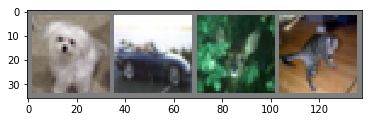

  dog   car  deer   cat


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片


def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 获取图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 展示图片
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 模型搭建及训练

通过 pytorch 搭建这次的的CNN模型.

#### 整个模型的结构如下

    考虑到计算机资源, 因此模型搭建的尽可能简单

- 两个filter层叠加, 每个filter层叠加一个pooling层, 两个filter的大小均为(5,5)

- 两个filter层中间进行一次 maxpooling 下采样

- 最后是三个全连接层, 前两个通过relu函数激活



In [5]:
import torch.nn as nn
import torch.nn.functional as F

#定义CNN模型

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

设置GPU运行

In [7]:

torch.cuda.set_device(0)

### 训练模型

对所有的trainloader中的数据迭代两次

每200个batch打印一次结果

损失函数使用交叉熵

In [6]:
for epoch in range(2):  # 循环两次
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)

        #每次将optimizater的参数归零
        optimizer.zero_grad()

        # 迭代更新参数
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000 个 batch 打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.229
[1,  4000] loss: 1.859
[1,  6000] loss: 1.654
[1,  8000] loss: 1.555
[1, 10000] loss: 1.496
[1, 12000] loss: 1.439
[2,  2000] loss: 1.379
[2,  4000] loss: 1.364
[2,  6000] loss: 1.343
[2,  8000] loss: 1.333
[2, 10000] loss: 1.291
[2, 12000] loss: 1.249
Finished Training


用训练后的模型给图片打标签

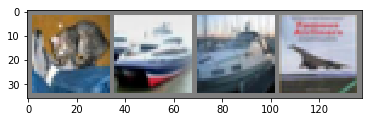

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


### 模型训练结果

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 71 %
Accuracy of  bird : 40 %
Accuracy of   cat : 45 %
Accuracy of  deer : 32 %
Accuracy of   dog : 32 %
Accuracy of  frog : 76 %
Accuracy of horse : 66 %
Accuracy of  ship : 56 %
Accuracy of truck : 66 %
